In [4]:

# Install dependencies
#Remember to execute this before running any of the exercises
!pip install tenacity==9.0.0
!pip install langchain==0.3.12
!pip install llama-index-llms-openai==0.1.27
!pip install langchain-openai==0.2.12
!pip install langchain_community==0.3.12
!pip install langgraph==0.2.59
!pip install pysqlite3-binary==0.5.4
!pip install langchain_chroma==0.1.4
!pip install pandas==2.2.3
!pip install pypdf==5.1.0
!pip install nbformat==5.10.4

  Using cached llama_index_llms_openai-0.1.27-py3-none-any.whl.metadata (610 bytes)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached dirtyjson-1.0.8-py3-none-any.whl.metadata (11 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached greenlet-3.2.4-cp313-cp313-macosx_11_0_universal2.whl.metadata (4.1 kB)
Using cached llama_index_llms_openai-0.1.27-py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s  0:00:009.4 MB/s eta 0:00:01
Using cached dirtyjson-1.0.8-py3-none-any.whl (25 kB)
Using cached tenacity-8.5.0-py3-none-any.whl (28 kB)
Using cached Deprecated-1.2.18-py2.py3-none-any.whl (10.0 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:

from langchain_openai import ChatOpenAI
from llama_index.llms.openai import OpenAI

import os
from dotenv import load_dotenv

# Load variables from .env into environment
load_dotenv()

# Now you can access the key
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

model = ChatOpenAI(
    model="gpt-4o"
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/r2/Documents/Projects/agentic-ai-
[nltk_data]     apps/jupyter_env/lib/python3.13/site-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:

summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article. 
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""

In [7]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class SummaryAgent:
    
    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug=False):
        
        self.model=model
        self.summarizer_prompt=summarizer_prompt
        self.reviewer_prompt=reviewer_prompt
        self.debug=debug
    
        summary_agent_graph=StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer",self.generate_summary)
        summary_agent_graph.add_node("reviewer",self.review_summary)

        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True: "reviewer", False: END }
        )
        summary_agent_graph.add_edge("reviewer", "summarizer")
        summary_agent_graph.set_entry_point("summarizer")

        #Add chat memory
        self.memory=MemorySaver()
        #Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

    def generate_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages
        
        #invoke the summarizer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"==============\n Generator returned output : {result.content}")
        return { "messages":[result] }

    def review_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages
        
        #invoke the reviewer with the message history
        result = self.model.invoke(messages)
        
        if self.debug:
            print(f"*************\n Reviewer returned output : {result.content}")
        return { "messages":[result] }

    def should_continue(self, state:SummaryAgentState):

        total_reviews = len(state["messages"]) / 2
        
        if self.debug:
            print(f"Iteration number : { total_reviews }")

        #Return if 2 iterations are completed. Each iteration has 2 messages
        if len(state["messages"]) > 4:
            return False
        else:
            return True

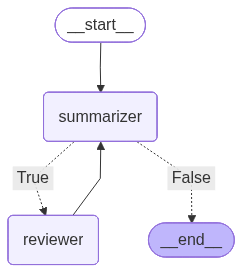

In [8]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

#Setup the summary chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=True)

Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())

In [9]:
#Input file for execution
# Load, chunk and index the contents of the pdf.
loader=PyPDFLoader("./data/EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ")
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

In [10]:
import uuid
#Execute a single request with debug ON
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages=[HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)

 Generator returned output : The EcoSprint is a cutting-edge electric vehicle designed for efficiency, performance, and style, ideal for city driving. It features a modern aerodynamic design, luxurious interior, a powerful electric motor, a 250-mile range, and advanced infotainment, safety, and security systems.
Iteration number : 1.0
*************
 Reviewer returned output : The summary effectively captures the key aspects of the EcoSprint, such as its design, performance, and features. However, it could be improved by mentioning specific specifications like the 200 horsepower, 50kWh battery, or 0-60 mph acceleration time for a more detailed overview.
 Generator returned output : The EcoSprint is a revolutionary electric vehicle designed for efficiency and performance, ideal for city driving. It features a sleek design, luxurious interior, 200 horsepower, a 50kWh battery offering a 250-mile range, and accelerates from 0-60 mph in 7.3 seconds. Advanced infotainment, safety, and securit

In [11]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=False)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons